# Detectando o Invisível: Como a Análise de Dados Pode Prevenir Fraudes em Transações Bancárias
## Notebook 02 — Engenharia de Features

---

**Objetivo:** Construir novas variáveis (features) que representem padrões de comportamento suspeito.

**Entradas:** Dataset limpo (`fraud_clean.csv`).\
**Saídas:** Base enriquecida (`df_features.csv`) e tabela consolidada de risco relativo das features derivadas (`consolidated_risk_table_derived_features.csv`).

---

### Estrutura deste notebook
4. Engenharia de Features\
   4.1. Features Derivadas\
   4.2. Consolidação do Dataframe: df_features\
   4.3. Tabela de Risco Relativo - Features Derivadas\
   4.4. Comparação: Features originais vs derivadas\
   4.5. Conclusões

### Importing the libraries

Carregando: ['pd', 'sns', 'plt', 'mpl', 'np']
------------------------------
✅ pd (pandas)
✅ sns (seaborn)
✅ plt (matplotlib.pyplot)
✅ mpl (matplotlib)
✅ np (numpy)

VERSÕES:
Python: 3.10.2
pandas: 2.2.2
seaborn: 0.13.2
matplotlib: 3.8.4
matplotlib: 3.8.4
numpy: 1.26.4

Bibliotecas disponíveis diretamente (IPython): ['pd', 'sns', 'plt', 'mpl', 'np']


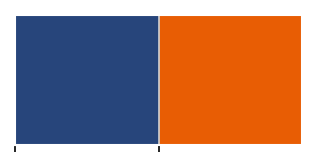

In [1]:
# Data manipulation and visualization.
import sys
sys.path.append('../src')

from utils import profiling as prof
from utils.lib_loader import carregar_libs
carregar_libs(['pd','sns','plt','mpl','np'])

from visualization import eda_graphs as edag
from utils.eda_aux import *

pd.set_option('display.max_columns', None)

### Visualization Settings
%matplotlib inline

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.max_open_warning'] = 50

mpl.style.use('ggplot') 
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

# Palette Setting and Display
color_palette = ['#27457B', '#e85d04']
sns.set_palette(sns.color_palette(color_palette))
sns.color_palette(color_palette)
sns.palplot(color_palette)

## Importação e Visão Geral

In [2]:
df = pd.read_csv('../data/interim/fraud_clean.csv')
df.head()

,transaction_id,merchant_id,user_id,hash_card_number,transaction_date,transaction_amount,device_id,has_cbk,has_device_info,transaction_day,transaction_time,transaction_hour,part_of_day,day_of_week,is_weekend,first_transaction,time_diff_min,time_diff_less_1h
0,21320398,29744,97051,cn_225730bfed215e86fcb14e416783716d42c37eb87b0...,2019-12-01 23:16:32.812632,374.56,285475.0,0,1,2019-12-01,23:16:32.812632,23,Evening,Domingo,1,1,0.000000,1th transaction
1,21320399,92895,2708,cn_1026e63cb76b5fdaeab4f472b47236d4539cf48d2ec...,2019-12-01 22:45:37.873639,734.87,497105.0,1,1,2019-12-01,22:45:37.873639,22,Evening,Domingo,1,0,2624.721795,> 1h
2,21320400,47759,14777,cn_a44e42e0d67ad8cdac30990f2f1f8718c74a03c4d40...,2019-12-01 22:22:43.021495,760.36,unknown_device,0,0,2019-12-01,22:22:43.021495,22,Evening,Domingo,1,1,0.000000,1th transaction
3,21320401,68657,69758,cn_fa68ce07344577d64f20949a4aea6159020655897c7...,2019-12-01 21:59:19.797129,2556.13,unknown_device,1,0,2019-12-01,21:59:19.797129,21,Evening,Domingo,1,0,161.967766,> 1h
4,21320402,54075,64367,cn_3c6a38fd69a2ab71859017440efa3d722a97c209cf7...,2019-12-01 21:30:53.347051,55.36,860232.0,0,1,2019-12-01,21:30:53.347051,21,Evening,Domingo,1,1,0.000000,1th transaction


In [3]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 3199 rows and 18 columns.


### Data dictionary

| Variáveis Originais  |
|:---------------------|

| Variável           | Descrição                                         | Tipo                 |
|:-------------------|:--------------------------------------------------|:---------------------|
| transaction_id     | Identificador único da transação                  | String/ID            |
| merchant_id        | Identificador do estabelecimento comercial        | String/ID            |
| user_id            | Identificador do usuário que realizou a transação | String/ID            |
| hash_card_number   | Número do cartão usado (hash/anonimizado)         | String/ID            |
| transaction_date   | Data e hora da transação                          | DateTime             |
| transaction_amount | Valor monetário da transação (R$)                 | Numerical continuous |
| device_id          | Identificador do dispositivo usado na transação   | String/ID            |
| has_cbk            | Target: 1 = Fraude (chargeback), 0 = Legítimo     | Binary (0/1)         |

---

| Novas Variáveis    |
|:-------------------|

| Variável            | Descrição                                                                                    | Tipo                   |
|:--------------------|:---------------------------------------------------------------------------------------------|:-----------------------|
| has_device_info     | Indica se há informação de dispositivo disponível                                            | Binary (0/1)           |
| transaction_day     | Dia do mês em que a transação ocorreu                                                        | Numerical discrete     |
| transaction_time    | Horário completo da transação                                                                | Time                   |
| transaction_hour    | Hora do dia da transação (0–23)                                                              | Numerical discrete     |
| part_of_day         | Período do dia (madrugada, manhã, tarde, noite)                                              | Categorical            |
| day_of_week         | Dia da semana da transação                                                                   | Categorical            |
| is_weekend          | Indica se a transação ocorreu no fim de semana                                               | Binary (0/1)           |
| first_transaction   | Indica se é a primeira transação do usuário                                                  | Binary (0/1)           |
| time_diff_min       | Diferença de tempo (em minutos) para a transação anterior do usuário                         | Numerical continuous   |
| time_diff_less_1h   | Indica se a transação ocorreu em menos de 1h após a anterior                                 | Categorical            |
| anomalous_value     | Indica se o valor da transação é anômalo em relação ao histórico do usuário                  | Binary (0/1)           |
| value_exc_max       | Indica se o valor da transação excede o máximo histórico do usuário                          | Binary (0/1)           |
| burst_transaction   | Indica padrão de múltiplas transações em curto intervalo de tempo                            | Binary (0/1)           |
| multi_card_flag     | Indica uso de múltiplos cartões pelo mesmo usuário                                           | Binary (0/1)           |
| multi_device_flag   | Indica uso de múltiplos dispositivos pelo mesmo usuário                                      | Binary (0/1)           |
| user_fraud_above_50 | Indica se o usuário possui taxa histórica de fraude > 50%                                    | Binary (0/1)           |
| comb_a              | Combinação de 'alor alto' + 'horário noturno', capturando risco composto                     | Binary (0/1)           |
| nighttime_flag      | Indica se a transação ocorreu entre 19h e 3h                                                 | Binary (0/1)           |

# 4. Engenharia de Features

Com base nos padrões identificados na análise exploratória, esta etapa tem como objetivo converter os principais insights em variáveis mensuráveis que representem o comportamento de risco.

Cada fator identificado, como valores elevados, transações em sequência, múltiplos dispositivos e horários de maior incidência, é transformado em indicadores numéricos ou binários, prontos para uso na modelagem supervisionada.

## 4.1. Features Derivadas

### **4.1.1. Feature 1: 'anomalous_value'**

#### **Motivação**

Na Seção 3 observamos:

- Valores elevados apresentam risco crescente de fraude.
- Usuários fraudulentos costumam realizar transações significativamente acima do padrão dos usuários legítimos.

Esses achados reforçam que valores extremos, especialmente quando destoam do histórico individual do cliente, são um sinal importante de risco.

#### **Hipótese**

Transações cujo valor ultrapassa de forma relevante o comportamento típico do usuário são mais prováveis de serem fraudulentas do que legítimas.

#### **Definição da Feature**

```
anomalous_value = 1 se (transaction_amount > previous_mean_value + 2 × previous_std_value)
                  0 caso contrário
```

In [4]:
# manter a ordem original para restaurar no final
df['original_order'] = df.index

df = df.sort_values(['user_id', 'transaction_date'])

media_global = df[df['first_transaction'] == 1]['transaction_amount'].mean()
std_global = df[df['first_transaction'] == 1]['transaction_amount'].std()

# Média acumulada (até transação ANTERIOR)
df['previous_mean_value'] = (
    df.groupby('user_id')['transaction_amount']
      .transform(lambda x: x.shift(1).expanding().median())
      .fillna(media_global)
)
                                                                        
# Desvio acumulado (até transação ANTERIOR)
df['previous_std_value'] = (
    df.groupby('user_id')['transaction_amount']
      .transform(lambda x: x.shift(1).expanding().std())
      .fillna(std_global)
)

# FEATURE: 'valor_anomalo'

df['anomalous_threshold'] = (df['previous_mean_value'] + 2 * df['previous_std_value'])
df['anomalous_value'] = (df['transaction_amount'] > df['anomalous_threshold']).astype(int)

# voltar à ordem original
df = df.sort_values('original_order').drop(columns='original_order')

<br>

#### **Análise Bivariada**

<br>


────────────────────────────────────────────────────────────────────────────────
Análise Bivariada Categórica: anomalous_value
────────────────────────────────────────────────────────────────────────────────



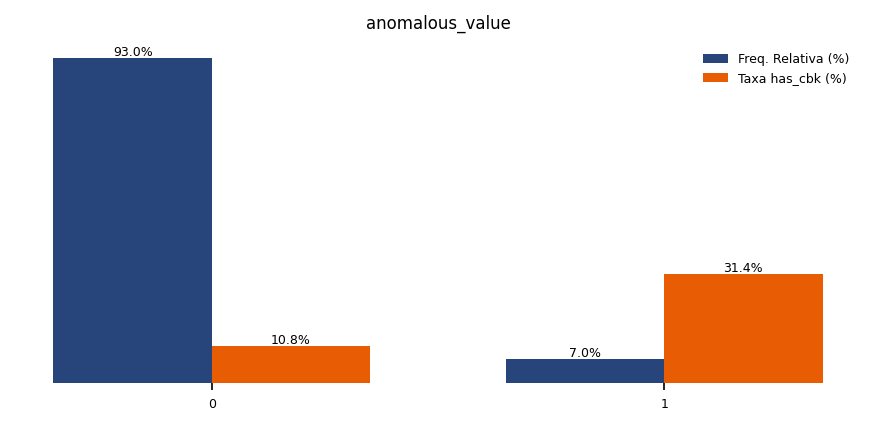


────────────────────────────────────────────────────────────────────────────────
Tabela de Análise de Risco: anomalous_value
────────────────────────────────────────────────────────────────────────────────



,anomalous_value,N Transações,N Has_cbk,Taxa Has_cbk,Risco Relat.
0,0,2976,321,10.8%,0.88x
1,1,223,70,31.4%,2.57x
2,TOTAL,3199,391,12.2%,1.00x


In [5]:
rt_anomalous_value = edag.cat_binary_analysis(data=df, features=['anomalous_value'], hue='has_cbk', figsize=(6,3))

---

💡 **Insights:** `anomalous_value`

Transações anômalas em relação ao padrão individual do usuário apresentam risco de fraude ~2,6x maior do que transações dentro do comportamento esperado.

Fraudadores realizam transações desproporcionais ao comportamento histórico da vítima e frequentemente testam limites com compras acima da média + múltiplos desvios, gerando picos de valor.

---

#### **Decisão para o Modelo**

A feature será utilizada no score por oferecer um sinal adicional e independente do valor absoluto da transação.
Ela não é dominante sozinha, mas contribui de forma importante para capturar mudanças bruscas no padrão do usuário.

<br>
<br>

### **4.1.2. Feature 2: 'value_exc_max'**

#### **Motivação**

Na Seção 3 observamos:

- Valores extremos concentram grande parte das fraudes.
- Fraudadores realizam compras com valores consistentemente mais altos, buscando maximizar ganhos.
- Valores “fora do padrão individual”, mesmo quando não são altos em termos absolutos, são fortes indicadores de comportamento suspeito.

Essas evidências motivam a criação de uma feature que sinalize quando a transação atual excede o valor máximo histórico do usuário.

#### **Hipótese**

Transações cujo valor excede o maior valor histórico do usuário têm maior probabilidade de serem fraudulentas.

#### **Definição da Feature**

A feature `value_exc_max` representa se o valor atual de transação é maior que o maior valor já registrado anteriormente pelo mesmo usuário.

```
value_exc_max = 1  se transaction_amount > max(valor_historico_usuario)
                0  se caso contrário
```

In [6]:
# manter a ordem original para restaurar no final
df['original_order'] = df.index

df = df.sort_values(['user_id', 'transaction_date'])

# máximo anterior (máx acumulado dentro do usuário, deslocado 1 p/ trás)
df['prev_max'] = (
    df.groupby('user_id')['transaction_amount']
      .transform(lambda s: s.shift(1).cummax())
      .fillna(0)
)

# FEATURE: 'value_exc_max'

df['value_exc_max'] = ((df['transaction_amount'] > df['prev_max']) & (df['first_transaction'] == 0)).astype(int)

# voltar à ordem original
df = df.sort_values('original_order').drop(columns='original_order')

In [7]:
df[df['user_id'] == 75710][['user_id', 'transaction_date', 'has_cbk', 'first_transaction', 'transaction_amount', 'prev_max', 'value_exc_max']]

,user_id,transaction_date,has_cbk,first_transaction,transaction_amount,prev_max,value_exc_max
2883,75710,2019-11-09 20:11:57.306777,1,0,1631.24,599.13,1
2922,75710,2019-11-09 00:58:24.689418,1,0,593.78,599.13,0
2923,75710,2019-11-09 00:17:27.310174,1,0,559.01,599.13,0
2927,75710,2019-11-08 23:18:28.634342,1,0,254.25,599.13,0
2928,75710,2019-11-08 23:17:08.619645,1,0,473.44,599.13,0
2929,75710,2019-11-08 23:15:05.322183,1,0,599.13,540.81,1
2930,75710,2019-11-08 23:14:35.977303,1,0,386.82,540.81,0
2931,75710,2019-11-08 23:12:00.465991,1,0,254.37,540.81,0
2932,75710,2019-11-08 23:11:18.971808,1,0,320.96,540.81,0
2933,75710,2019-11-08 23:05:13.814924,1,1,540.81,0.00,0


<br>

#### **Análise Bivariada**

<br>


────────────────────────────────────────────────────────────────────────────────
Análise Bivariada Categórica: value_exc_max
────────────────────────────────────────────────────────────────────────────────



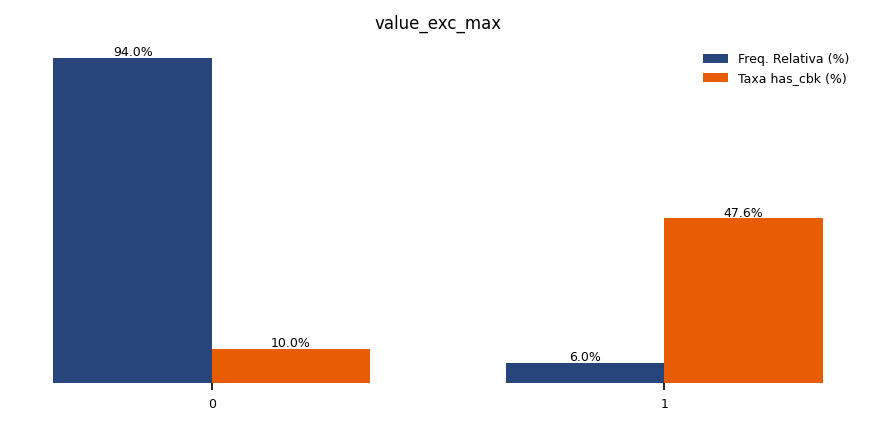


────────────────────────────────────────────────────────────────────────────────
Tabela de Análise de Risco: value_exc_max
────────────────────────────────────────────────────────────────────────────────



,value_exc_max,N Transações,N Has_cbk,Taxa Has_cbk,Risco Relat.
0,0,3008,300,10.0%,0.82x
1,1,191,91,47.6%,3.9x
2,TOTAL,3199,391,12.2%,1.00x


In [8]:
rt_value_exc_max = edag.cat_binary_analysis(data=df, features=['value_exc_max'], hue='has_cbk', figsize=(6,3))

---

💡 **Insights:** `value_exc_max`

A feature apresenta forte poder discriminativo:

- Transações que excedem o maior valor do usuário têm risco ~4x maior.
- Esse padrão é amplamente documentado na indústria de risco e na literatura, reforçando sua validade teórica.
- No nosso dataset, o grupo `value_exc_max = 1` concentra pouca quantidade de transações, mas enorme densidade de fraude.

Porém, há uma limitação importante:

O dataset possui apenas 30 dias de histórico, fazendo com que a maioria dos usuários (92.6%) tenha somente 1 transação e consequentemente, para essa classe, não exista valor máximo histórico real para comparar.
Isso significa que o padrão observado é mais forte entre usuários que de fato possuem mais de uma transação.
A feature é válida, mas o dataset amplifica artificialmente sua força porque usuários legítimos quase nunca têm 2ª transação no período analisado.

---

#### **Decisão para o Modelo**

A feature será usada como variável categórica binária, com peso moderado no score.
Devido ao viés temporal do dataset, aplicamos peso conservador, mas mantemos a variável porque representa um padrão clássico de comportamento fraudulento.
Em produção (com histórico real de meses), esperamos que esta feature ganhe força e estabilidade.

<br>
<br>

### **4.1.3. Feature 3: 'burst_transaction'**

#### **Motivação**

Na Seção 3 observamos:

- Fraudadores realizam transações em sequência curta, frequentemente dentro da mesma hora. Esse comportamento aparece porque eles tentam explorar cartões roubados rapidamente antes do bloqueio.
- Taxas de fraude são elevadas quando múltiplas transações ocorrem em janelas de curto período (≤1h), alcançando valores acima de 60%.

Esse padrão reforça a necessidade de uma feature que capture rajadas de transações em pequenas janelas temporais.

#### **Hipótese**

Usuários que realizam duas ou mais transações dentro de uma janela de 1 hora têm probabilidade muito maior de estarem envolvidos em fraude.

#### **Definição da Feature**

```
burst_transaction = 1  se o usuário realizou ≥2 transações em ≤1 hora
                    0  caso contrário
```

In [9]:
# FEATURE: 'burst_transaction'

df['n_transaction'] = df.groupby(['user_id', 'transaction_day', 'transaction_hour']).transform('size')
df['burst_transaction'] = (df['n_transaction'] >= 2).astype(int)

In [10]:
df[df['user_id'] == 75710][['user_id', 'transaction_day', 'transaction_hour', 'n_transaction', 'burst_transaction', 'has_cbk']]

,user_id,transaction_day,transaction_hour,n_transaction,burst_transaction,has_cbk
2883,75710,2019-11-09,20,1,0,1
2922,75710,2019-11-09,0,2,1,1
2923,75710,2019-11-09,0,2,1,1
2927,75710,2019-11-08,23,7,1,1
2928,75710,2019-11-08,23,7,1,1
2929,75710,2019-11-08,23,7,1,1
2930,75710,2019-11-08,23,7,1,1
2931,75710,2019-11-08,23,7,1,1
2932,75710,2019-11-08,23,7,1,1
2933,75710,2019-11-08,23,7,1,1


<br>

#### **Análise Bivariada**

<br>


────────────────────────────────────────────────────────────────────────────────
Análise Bivariada Categórica: burst_transaction
────────────────────────────────────────────────────────────────────────────────



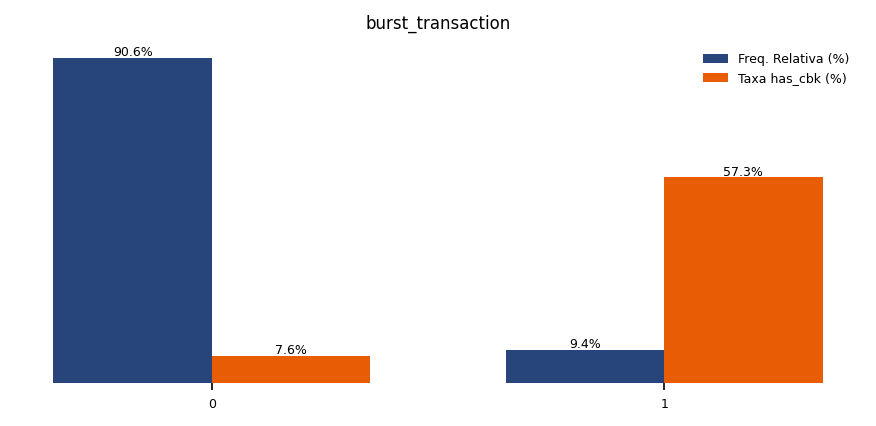


────────────────────────────────────────────────────────────────────────────────
Tabela de Análise de Risco: burst_transaction
────────────────────────────────────────────────────────────────────────────────



,burst_transaction,N Transações,N Has_cbk,Taxa Has_cbk,Risco Relat.
0,0,2899,219,7.6%,0.62x
1,1,300,172,57.3%,4.69x
2,TOTAL,3199,391,12.2%,1.00x


In [11]:
rt_burst_transaction = edag.cat_binary_analysis(data=df, features=['burst_transaction'], hue='has_cbk', figsize=(6,3))

---

💡 **Insights:** `burst_transaction`

A feature apresenta forte poder discriminativo:

- Rajadas de transações em janelas curtas são um dos sinais mais clássicos de fraude.
- A taxa de fraude sobe de 7.6% para 57.3% quando há rajada com risco relativo de 4.69x.

Essa é uma das features mais consistentes e estáveis para detecção de comportamento suspeito, amplamente corroborada pela literatura e pela prática da indústria.

A feature `burst_transaction` não depende de histórico longo do usuário, portanto não é afetada pelo viés temporal do dataset.

---

#### **Decisão para o Modelo**

`burst_transaction` será usada como variável categórica binária com peso forte, pois adiciona um dos sinais mais importantes de fraude: velocidade de ataque.
É altamente complementar às demais features de valor e comportamento e deve receber peso elevado no score.

<br>
<br>

### **4.1.4. Feature 4: 'nighttime_flag'**

#### **Motivação**

Na Seção 3 observamos:

- Atividades noturnas apresentam risco elevado: transações realizadas no período noturno (18h as 5h) registram taxas de fraude acima da média, entre 15.2% e 17.5%, com risco relativo de até 1.44x. 
- Essa faixa de horário coincide com períodos de menor vigilância por parte das vítimas e menor capacidade de resposta do suporte bancário.
- Fraudadores preferem operar à noite para reduzir chances de detecção e contestação imediata.

#### **Hipótese**

Transações realizadas em horário noturno específico (entre 19h e 2h) têm probabilidade maior de serem fraudulentas.

#### **Definição da Feature**

```
nighttime_flag = 1  se a transação ocorreu entre 19:00h e 02:00h
                 0  caso contrário
```

Essa janela foi escolhida com base nos padrões observados no EDA, onde o risco de fraude se intensifica nesses horários.

In [12]:
# FEATURE: 'nighttime_flag'

df['nighttime_flag'] = ((df['transaction_hour'] <= 2) | (df['transaction_hour'] >= 19)).astype(int)
df[['transaction_hour', 'nighttime_flag', 'has_cbk']].sample(n=10, random_state=41)

,transaction_hour,nighttime_flag,has_cbk
78,15,0,0
150,0,1,0
2096,20,1,0
1859,17,0,0
2957,18,0,0
1233,11,0,0
1155,19,1,1
397,3,0,0
345,14,0,0
352,14,0,0


<br>

#### **Análise Bivariada**

<br>


────────────────────────────────────────────────────────────────────────────────
Análise Bivariada Categórica: nighttime_flag
────────────────────────────────────────────────────────────────────────────────



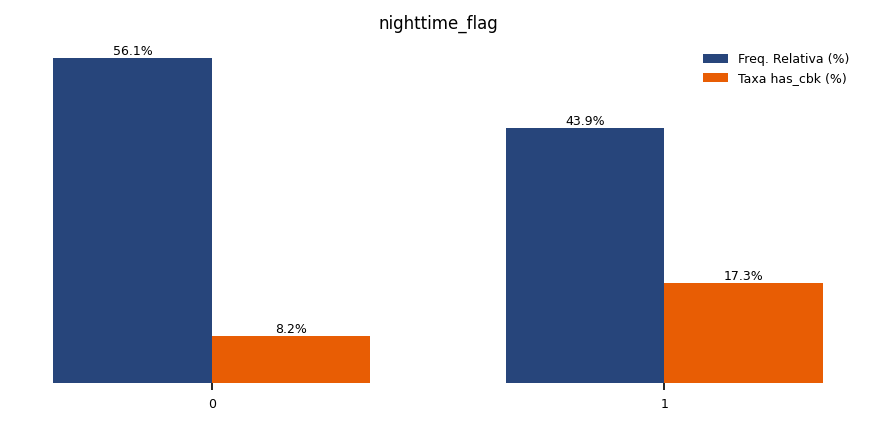


────────────────────────────────────────────────────────────────────────────────
Tabela de Análise de Risco: nighttime_flag
────────────────────────────────────────────────────────────────────────────────



,nighttime_flag,N Transações,N Has_cbk,Taxa Has_cbk,Risco Relat.
0,0,1794,148,8.2%,0.67x
1,1,1405,243,17.3%,1.42x
2,TOTAL,3199,391,12.2%,1.00x


In [13]:
rt_nighttime_flag = edag.cat_binary_analysis(data=df, features=['nighttime_flag'], hue='has_cbk', figsize=(6,3))

---

💡 **Insights:** `nighttime_flag`

A feature apresenta bom poder discriminativo, ainda que não tão forte quanto as outras variáveis:

- O risco mais que dobra entre o horário regular e o horário noturno.
- Padrão consistente com literatura e práticas de antifraude (fraudes tendem a ocorrer quando usuários e instituições estão menos atentas).

Diferente de features de histórico, `nighttime_flag` não depende de múltiplas transações do usuário, portanto não é afetada pelo viés temporal do dataset.

---

#### **Decisão para o Modelo**

Embora `nighttime_flag` apresente risco moderado, seu efeito ainda pode ser potencializado se combinado com outras váriaveis.
Por isso, a utilização da feature será avaliada na análise da feature `comb_a`, que combina horário noturno e valor elevado.

<br>
<br>

### **4.1.5. Feature 5: 'comb_a'**

#### **Motivação**

Na Seção 3 observamos:

- Valores altos concentram fraudes, transações acima de R$ 2.500 apresentam taxas entre 37% e 55%, com risco relativo de até 5x.
- Atividade noturna apresenta maior risco, transações entre 19h e 3h têm risco 1.42x acima do normal.

Esses padrões sugerem que fraudadores intensificam ataques à noite, executando transações de maior valor para maximizar o ganho antes do bloqueio. A combinação desses fatores cria um perfil forte de comportamento suspeito.

#### **Hipótese**

Transações de alto valor realizadas no período noturno apresentam risco muito superior ao risco de cada um desses fatores isoladamente.

#### **Definição da Feature**

```
comb_a = 1  se (transaction_amount > 2500) E (nighttime_flag = 1)
         0  caso contrário
```
Essa combinação captura cenários típicos de fraude de alto impacto: transações grandes, realizadas em momentos com menor vigilância.

In [14]:
# Combinação A: transaction_amount > R$ 2500 + Período Noturno

df['comb_a'] = (
    (df['transaction_amount'] > 2500) & 
    (df['nighttime_flag'] == 1)
).astype(int)

<br>

#### **Análise Bivariada**

<br>


────────────────────────────────────────────────────────────────────────────────
Análise Bivariada Categórica: comb_a
────────────────────────────────────────────────────────────────────────────────



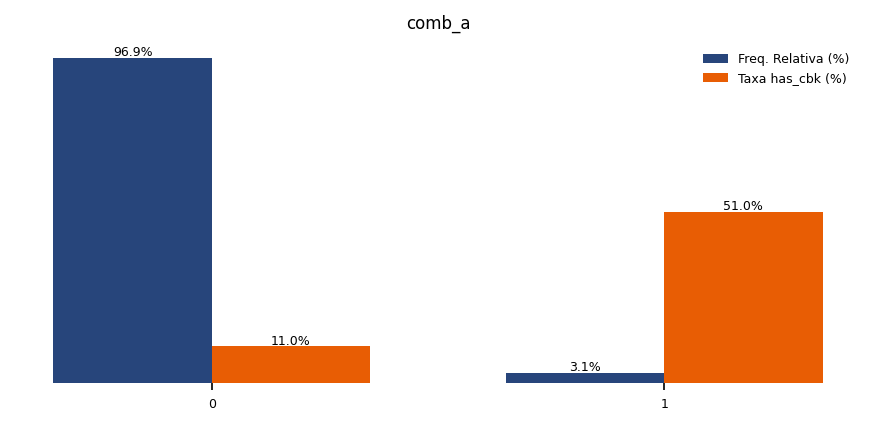


────────────────────────────────────────────────────────────────────────────────
Tabela de Análise de Risco: comb_a
────────────────────────────────────────────────────────────────────────────────



,comb_a,N Transações,N Has_cbk,Taxa Has_cbk,Risco Relat.
0,0,3101,341,11.0%,0.9x
1,1,98,50,51.0%,4.17x
2,TOTAL,3199,391,12.2%,1.00x


In [15]:
rt_comb_a = edag.cat_binary_analysis(data=df, features=['comb_a'], hue='has_cbk', figsize=(6,3))

---

💡 **Insights:** `comb_a`

A feature apresenta sinal forte e altamente específico:

- Ela captura um dos cenários mais clássicos de fraude: transações grandes feitas à noite.
- A taxa de fraude sobe de 11% para 51%, indicando que essa combinação gera um comportamento altamente discriminante.
- O risco relativo de 4.17x confirma que a interseção dos dois sinais amplifica o risco mais do que cada sinal isoladamente.

Além disso, a feature `comb_a` não depende de histórico longo do usuário, portanto não é afetada pelo viés temporal do dataset.

---

#### **Decisão para o Modelo**

A análise mostrou que a combinação dos dois fatores, horário noturno e valor elevado, apresenta risco maior do que o horário isolado.\
Apesar disso, a variável `comb_a` será aplicada e análisada no score em conjunto com `nighttime_flag`, visando a possibilidade de otimização na captura de fraudes.

<br>
<br>

### **4.1.6. Feature 6: 'multi_card_flag'**

#### **Motivação**

Na Seção 3 observamos:

- Usuários que utilizam mais de um cartão apresentam risco extremamente elevado.
- Enquanto usuários com 1 cartão possuem taxas de fraude em torno de 3.7%, aqueles com 2 cartões sobem para ~29%, e com 3+ cartões o risco dispara para mais de 50%.

Esse comportamento está alinhado com práticas comuns de fraude, onde criminosos testam cartões roubados em sequência, alternando entre eles para tentar contornar bloqueios automáticos. Por isso, criar uma feature binária que identifique múltiplos cartões por usuário é essencial.

#### **Hipótese**

Usuários que utilizam dois ou mais cartões têm probabilidade muito maior de cometer fraude.

#### **Definição da Feature**

```
multi_card_flag = 1  se o usuário usou ≥ 2 cartões diferentes
                  0  se o usuário usou apenas 1 cartão
```

In [16]:
# manter a ordem original para restaurar no final
df['original_order'] = df.index

df = df.sort_values(['user_id', 'transaction_date'])

df['is_first_seen'] = ~df.duplicated(subset=['user_id', 'hash_card_number'], keep='first')

# Contagem Acumulada
df['card_unique_cumcount'] = (
    df.groupby('user_id')['is_first_seen']
      .cumsum()
)

# Shift para T-1
df['prev_card_unique_cumcount'] = (
    df.groupby('user_id')['card_unique_cumcount']
      .shift(1)
      .fillna(0)
      .astype(int)
)

# FEATURE: 'multi_card_flag'

df['multi_card_flag'] = (df['prev_card_unique_cumcount'] >= 2).astype(int)

# voltar à ordem original
df = df.sort_values('original_order').drop(columns='original_order')

df[df['user_id'] == 78262][['user_id', 'transaction_date', 'hash_card_number', 'is_first_seen', 'card_unique_cumcount', 'prev_card_unique_cumcount', 'multi_card_flag']]

,user_id,transaction_date,hash_card_number,is_first_seen,card_unique_cumcount,prev_card_unique_cumcount,multi_card_flag
1259,78262,2019-11-25 17:42:16.389973,cn_f4b2c86250c4805b2abbf2fb3ff9adb2e8b7ac90fd1...,False,10,10,1
1260,78262,2019-11-25 17:30:49.997119,cn_f4b2c86250c4805b2abbf2fb3ff9adb2e8b7ac90fd1...,True,10,9,1
1276,78262,2019-11-25 13:31:33.648356,cn_bf6e9aeaa4c91a52c0d284ef7192495310eee1aee8e...,False,9,9,1
1277,78262,2019-11-25 13:11:05.092545,cn_bf6e9aeaa4c91a52c0d284ef7192495310eee1aee8e...,True,9,8,1
1289,78262,2019-11-25 00:30:54.488087,cn_fe02ebbf26ea967d5524334e31e9acea1d2de6994e8...,False,8,8,1
1293,78262,2019-11-24 23:02:24.777947,cn_fe02ebbf26ea967d5524334e31e9acea1d2de6994e8...,True,8,7,1
1692,78262,2019-11-22 23:50:09.761794,cn_34c5a8d7dffa7d24c6f0e1e11fcf2cedbc28a9b1033...,True,7,6,1
1707,78262,2019-11-22 22:54:27.376492,cn_4b18e98ab667ff84b0747b477164f2ec2f9b0ee0cae...,True,6,5,1
2127,78262,2019-11-21 19:41:36.793503,cn_6c23c68b4281a2abfcc4e09ea116a7101a5b55fb3b4...,True,5,4,1
2223,78262,2019-11-20 22:45:43.424580,cn_e36f06e626821b226a86e3d48abc75125b2257a7c35...,True,4,3,1


<br>

#### **Análise Bivariada**

<br>


────────────────────────────────────────────────────────────────────────────────
Análise Bivariada Categórica: multi_card_flag
────────────────────────────────────────────────────────────────────────────────



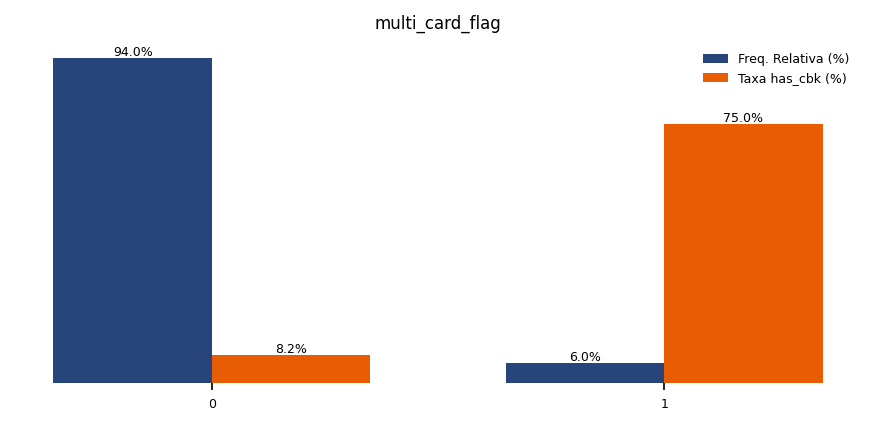


────────────────────────────────────────────────────────────────────────────────
Tabela de Análise de Risco: multi_card_flag
────────────────────────────────────────────────────────────────────────────────



,multi_card_flag,N Transações,N Has_cbk,Taxa Has_cbk,Risco Relat.
0,0,3007,247,8.2%,0.67x
1,1,192,144,75.0%,6.14x
2,TOTAL,3199,391,12.2%,1.00x


In [17]:
rt_multi_card_flag = edag.cat_binary_analysis(data=df, features=['multi_card_flag'], hue='has_cbk', figsize=(6,3))

---

💡 **Insights:** `multi_card_flag`

A feature apresenta um dos maiores sinais de risco de todo o dataset:

- A taxa de fraude aumenta de 8.2% para 75%, uma das maiores relações encontradas.
- O risco relativo de 6.14x é extremamente forte e consistente.
- É uma das features mais explicáveis: fraudadores frequentemente alternam cartões roubados tentando validar quais funcionam.

O dataset ser curto (30 dias) tem baixo impacto aqui, pois mesmo com poucos dias, usuários legítimos raramente usam múltiplos cartões. Dessa forma, esta é uma feature altamente robusta e pouco afetada pelo viés temporal do dataset.

---

#### **Decisão para o Modelo**

`multi_card_flag` será utilizada como feature binária de peso forte no score, contribuindo para identificar tentativas de fraude estruturada.

<br>
<br>

### **4.1.7. Feature 7: 'multi_device_flag'**

#### **Motivação**

Na Seção 3 observamos:

- Usuários que utilizam mais de um dispositivo apresentam risco extremamente elevado.
- Usuários legítimos tendem a operar exclusivamente do mesmo celular, enquanto fraudadores frequentemente alternam entre múltiplos dispositivos.
- Quando um usuário aparece utilizando ≥2 dispositivos, a taxa de fraude cresce para níveis superiores a 37%.

Esse padrão é amplamente documentado em sistemas antifraude e motivou a criação de uma feature que o capture.

#### **Hipótese**

Usuários que utilizam dois ou mais dispositivos diferentes têm probabilidade muito maior de cometer fraude do que usuários que usam apenas um.

#### **Definição da Feature**

```
multi_device_flag = 1  se o usuário usou ≥ 2 dispositivos distintos
                    0  se o usuário usou apenas 1 dispositivo
```

In [18]:
# manter a ordem original para restaurar no final
df['original_order'] = df.index

df = df.sort_values(['user_id', 'transaction_date'])

df['is_first_seen'] = ~df.duplicated(subset=['user_id', 'device_id'], keep='first')

# Contagem Acumulada
df['device_unique_cumcount'] = (
    df.groupby('user_id')['is_first_seen']
      .cumsum()
)

# Shift para T-1
df['prev_device_unique_cumcount'] = (
    df.groupby('user_id')['device_unique_cumcount']
      .shift(1)
      .fillna(0)
      .astype(int)
)

# FEATURE: 'multi_device_flag'

df['multi_device_flag'] = (df['prev_device_unique_cumcount'] >= 2).astype(int)

# voltar à ordem original
df = df.sort_values('original_order').drop(columns='original_order')

df[df['user_id'] == 99396][['user_id', 'transaction_date', 'device_id', 'device_unique_cumcount', 'prev_device_unique_cumcount', 'multi_device_flag', 'has_cbk']]

,user_id,transaction_date,device_id,device_unique_cumcount,prev_device_unique_cumcount,multi_device_flag,has_cbk
306,99396,2019-11-30 16:09:53.763866,834436.0,3,3,1,1
327,99396,2019-11-30 15:09:52.107909,248385.0,3,2,1,1
419,99396,2019-11-30 00:29:46.687445,834436.0,2,1,0,1
446,99396,2019-11-29 23:25:10.048906,278124.0,1,1,0,1
472,99396,2019-11-29 21:43:15.235182,278124.0,1,0,0,1


<br>

#### **Análise Bivariada**

<br>


────────────────────────────────────────────────────────────────────────────────
Análise Bivariada Categórica: multi_device_flag
────────────────────────────────────────────────────────────────────────────────



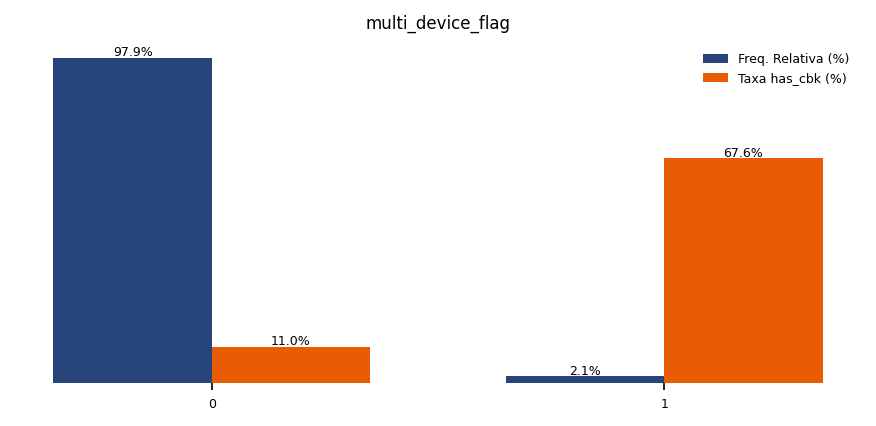


────────────────────────────────────────────────────────────────────────────────
Tabela de Análise de Risco: multi_device_flag
────────────────────────────────────────────────────────────────────────────────



,multi_device_flag,N Transações,N Has_cbk,Taxa Has_cbk,Risco Relat.
0,0,3131,345,11.0%,0.9x
1,1,68,46,67.6%,5.53x
2,TOTAL,3199,391,12.2%,1.00x


In [19]:
rt_multi_device_flag = edag.cat_binary_analysis(data=df, features=['multi_device_flag'], hue='has_cbk', figsize=(6,3))

---

💡 **Insights:** `multi_device_flag`

A feature apresenta um dos maiores sinais de risco de todo o dataset:

- A taxa de fraude aumenta de 11% para 67.6%, uma das maiores relações encontradas.
- O risco relativo é de 5.53x, similar ao observado em `multi_card_flag`.
- É uma das features mais explicáveis: fraudadores alternam dispositivos frequentemente.

Assim como `multi_card_flag`, o dataset ser curto tem baixo impacto aqui, pois mesmo em períodos curtos, fraudadores já tendem a alternar dispositivos. Dessa forma, esta é uma feature altamente robusta e pouco afetada pelo viés temporal do dataset.

O dataset ser curto (30 dias) tem baixo impacto aqui, pois mesmo com poucos dias, usuários legítimos raramente usam múltiplos cartões. Dessa forma, esta é uma feature altamente robusta e pouco afetada pelo viés temporal do dataset.

#### **Decisão para o Modelo**

`multi_device_flag` será utilizada como feature binária de peso forte no score, contribuindo para identificar tentativas de fraude estruturada.

<br>
<br>

### **4.1.8. Feature 8: 'user_fraud_above_50'**

#### **Motivação**

Na Seção 3 observamos:

- A fraude é extremamente concentrada em poucos usuários: apenas 6% dos usuários são responsáveis por todas as fraudes, enquanto usuários legítimos costumam ter poucas transações e baixo índice de chargeback.
- Fraudadores mostram comportamento repetitivo: realizam várias transações, teste de cartões e mantêm taxa de fraude pessoal alta.

Criar uma feature que capture se o usuário apresenta taxa de fraude acima de 50% ajuda a identificar perfis que consistentemente geram chargebacks. 

#### **Hipótese**

Usuários cuja taxa individual de fraude supera 50% têm probabilidade muito maior de continuar cometendo fraude em transações futuras.

#### **Definição da Feature**

```
user_fraud_above_50 = 1  se (n_fraudes_usuario / total_transacoes_usuario) > 0.5
                      0  caso contrário
```
A feature avalia o histórico do usuário, dessa forma para evitar data leakage, a taxa é sempre calculada somente com base em transações anteriores.

In [20]:
# manter a ordem original para restaurar no final
df['original_order'] = df.index

df = df.sort_values(['user_id', 'transaction_date'])

# máximo anterior (máx acumulado dentro do usuário, deslocado 1 p/ trás)
df['user_fraud_intensity'] = (
    df.groupby('user_id')['has_cbk']
      .transform(lambda x: x.shift(1).expanding().mean())
      .fillna(0)
)

# FEATURE: 'user_fraud_above_50'

df['user_fraud_above_50'] = (df['user_fraud_intensity'] > 0.5).astype(int)

# voltar à ordem original
df = df.sort_values('original_order').drop(columns='original_order')

In [21]:
df[df['user_id'] == 56877][['transaction_date','user_id', 'has_cbk', 'user_fraud_intensity', 'user_fraud_above_50', 'burst_transaction', 'has_cbk']]

,transaction_date,user_id,has_cbk,user_fraud_intensity,user_fraud_above_50,burst_transaction,has_cbk
316,2019-11-30 15:43:57.547585,56877,1,0.500000,0,1,1
320,2019-11-30 15:35:31.554331,56877,1,0.428571,0,1,1
329,2019-11-30 15:08:30.680104,56877,1,0.333333,0,1,1
337,2019-11-30 14:51:49.542823,56877,1,0.200000,0,1,1
338,2019-11-30 14:51:32.317215,56877,1,0.000000,0,1,1
383,2019-11-30 12:08:00.331138,56877,0,0.000000,0,0,0
386,2019-11-30 11:42:18.892456,56877,0,0.000000,0,0,0
1065,2019-11-27 20:15:49.006673,56877,0,0.000000,0,0,0
1108,2019-11-27 14:34:23.806435,56877,0,0.000000,0,0,0


<br>

#### **Análise Bivariada**

<br>


────────────────────────────────────────────────────────────────────────────────
Análise Bivariada Categórica: user_fraud_above_50
────────────────────────────────────────────────────────────────────────────────



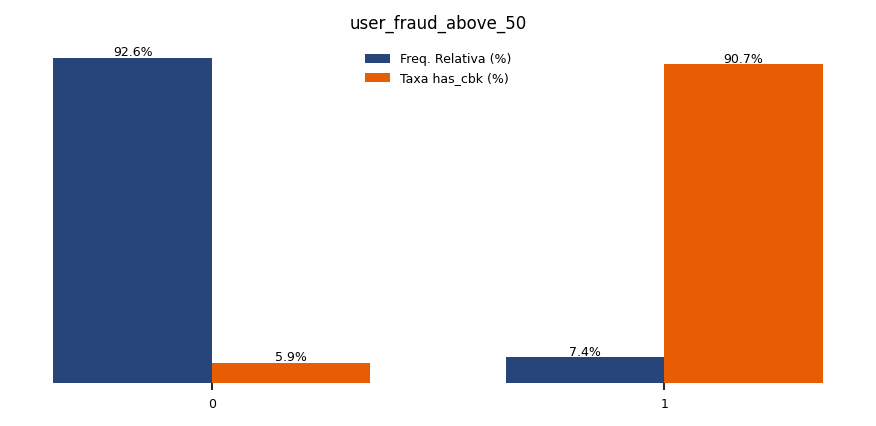


────────────────────────────────────────────────────────────────────────────────
Tabela de Análise de Risco: user_fraud_above_50
────────────────────────────────────────────────────────────────────────────────



,user_fraud_above_50,N Transações,N Has_cbk,Taxa Has_cbk,Risco Relat.
0,0,2962,176,5.9%,0.49x
1,1,237,215,90.7%,7.42x
2,TOTAL,3199,391,12.2%,1.00x


In [22]:
rt_user_fraud_above_50 = edag.cat_binary_analysis(data=df, features=['user_fraud_above_50'], hue='has_cbk', figsize=(6,3))

---

💡 **Insights:** `user_fraud_above_50`

A feature apresenta um dos maiores sinais de risco de todo o dataset:

* A taxa de fraude aumenta de 5.9% para 90.7%, uma das maiores relações encontradas.
* O risco relativo de 7.42× é um dos maiores registrados na análise.
* A feature captura diretamente perfis que repetidamente geram chargebacks. 

Essa feature é afetada parcialmente pelo fato de o dataset ter apenas 30 dias, porém isso não a invalida, pois fraudadores reincidentes aparecem de forma evidente mesmo em períodos curtos.

#### **Decisão para o Modelo**

`user_fraud_above_50` será usada como feature binária de peso muito forte no modelo, pois identifica comportamento reincidente e sistemático.

<br>
<br>

## 4.2. Consolidação do Dataframe: df_features

Salvaremos a base enriquecida com as novas features para posterior uso na construção do score e validação.

In [23]:
df_features = df[[ 'transaction_id', 	
                   'merchant_id', 	
                   'user_id', 	
                   'hash_card_number', 	
                   'transaction_date', 	
                   'transaction_amount', 	
                   'device_id', 	
                   'has_cbk', 	
                   'has_device_info', 	
                   'transaction_day', 	
                   'transaction_time', 	
                   'transaction_hour', 	
                   'part_of_day', 	
                   'day_of_week', 	
                   'is_weekend', 	
                   'first_transaction',
                   'time_diff_min',
                   'time_diff_less_1h',
                   'anomalous_value', 	
                   'value_exc_max', 	
                   'burst_transaction', 	 
                   'multi_card_flag', 	             
                   'multi_device_flag', 	
                   'user_fraud_above_50', 	
                   'comb_a',
                   'nighttime_flag']]

df_features.head()

,transaction_id,merchant_id,user_id,hash_card_number,transaction_date,transaction_amount,device_id,has_cbk,has_device_info,transaction_day,transaction_time,transaction_hour,part_of_day,day_of_week,is_weekend,first_transaction,time_diff_min,time_diff_less_1h,anomalous_value,value_exc_max,burst_transaction,multi_card_flag,multi_device_flag,user_fraud_above_50,comb_a,nighttime_flag
0,21320398,29744,97051,cn_225730bfed215e86fcb14e416783716d42c37eb87b0...,2019-12-01 23:16:32.812632,374.56,285475.0,0,1,2019-12-01,23:16:32.812632,23,Evening,Domingo,1,1,0.000000,1th transaction,0,0,0,0,0,0,0,1
1,21320399,92895,2708,cn_1026e63cb76b5fdaeab4f472b47236d4539cf48d2ec...,2019-12-01 22:45:37.873639,734.87,497105.0,1,1,2019-12-01,22:45:37.873639,22,Evening,Domingo,1,0,2624.721795,> 1h,0,1,0,0,0,0,0,1
2,21320400,47759,14777,cn_a44e42e0d67ad8cdac30990f2f1f8718c74a03c4d40...,2019-12-01 22:22:43.021495,760.36,unknown_device,0,0,2019-12-01,22:22:43.021495,22,Evening,Domingo,1,1,0.000000,1th transaction,0,0,0,0,0,0,0,1
3,21320401,68657,69758,cn_fa68ce07344577d64f20949a4aea6159020655897c7...,2019-12-01 21:59:19.797129,2556.13,unknown_device,1,0,2019-12-01,21:59:19.797129,21,Evening,Domingo,1,0,161.967766,> 1h,0,0,0,0,0,1,1,1
4,21320402,54075,64367,cn_3c6a38fd69a2ab71859017440efa3d722a97c209cf7...,2019-12-01 21:30:53.347051,55.36,860232.0,0,1,2019-12-01,21:30:53.347051,21,Evening,Domingo,1,1,0.000000,1th transaction,0,0,0,0,0,0,0,1


In [24]:
df_features.to_csv("../data/processed/df_features.csv", index=False)

## 4.3. Tabela de Risco Relativo - Features Derivadas

In [25]:
total_rt = edag.consolidate_risk_tables(tables=[rt_anomalous_value, 
                                         rt_value_exc_max, 
                                         rt_burst_transaction,
                                         rt_nighttime_flag,
                                         rt_comb_a, 
                                         rt_multi_card_flag, 
                                         rt_multi_device_flag,
                                         rt_user_fraud_above_50])
total_rt.head(8)

,feature,bin,n_total,n_has_cbk,has_cbk_rate,relative_risk,priority
0,user_fraud_above_50,1,237,215,90.7%,7.42,CRÍTICA
1,multi_card_flag,1,192,144,75.0%,6.14,CRÍTICA
2,multi_device_flag,1,68,46,67.6%,5.53,CRÍTICA
3,burst_transaction,1,300,172,57.3%,4.69,CRÍTICA
4,comb_a,1,98,50,51.0%,4.17,CRÍTICA
5,value_exc_max,1,191,91,47.6%,3.90,CRÍTICA
6,anomalous_value,1,223,70,31.4%,2.57,CRÍTICA
7,nighttime_flag,1,1405,243,17.3%,1.42,BAIXA


---

**Anotações:**

As features derivadas apresentaram um elevado poder preditivo, com várias delas exibindo risco relativo muito acima da média. O destaque principal é `user_fraud_above_50`, com risco relativo de 7.42x, isso confirma que histórico prévio é o fator mais forte na identificação de novos chargebacks. Da mesma forma, `multi_card_flag` (6.14x) e `multi_device_flag` (5.53x) mostraram-se altamente discriminativas, reforçando que variações no comportamento transacional do usuário têm forte relevância na identificação de fraude.

Por outro lado, `nighttime_flag` apresentou risco modesto (1.42x), indicando que o horário, isoladamente, é um indicador moderado.

---

## 4.4. Comparação: Features originais vs derivadas

In [26]:
total_rt_first_features = pd.read_csv("../data/interim/consolidated_risk_table_first_features.csv")

print("="*70)
print("Tabela de Risco Relativo - Features Originais")
print("="*70)

display(total_rt_first_features.head(8))

print("\n")
print("="*70)
print("Tabela de Risco Relativo - Features Derivadas")
print("="*70)

display(total_rt.head(8))

Tabela de Risco Relativo - Features Originais


,feature,bin,n_total,n_has_cbk,has_cbk_rate,relative_risk,priority
0,time_diff_less_1h,<= 1h,225,142,63.1%,5.16,CRÍTICA
1,first_transaction,0,495,260,52.5%,4.30,CRÍTICA
2,transaction_hour,6-7,2,1,50.0%,4.09,CRÍTICA
3,time_diff_less_1h,> 1h,270,118,43.7%,3.58,CRÍTICA
4,transaction_amount,>2500.0,222,83,37.4%,3.06,CRÍTICA
5,transaction_hour,2-3,61,18,29.5%,2.41,ALTA
6,transaction_amount,2000.0-2500.0,135,37,27.4%,2.24,ALTA
7,day_of_week,Quarta,157,34,21.7%,1.77,MÉDIA




Tabela de Risco Relativo - Features Derivadas


,feature,bin,n_total,n_has_cbk,has_cbk_rate,relative_risk,priority
0,user_fraud_above_50,1,237,215,90.7%,7.42,CRÍTICA
1,multi_card_flag,1,192,144,75.0%,6.14,CRÍTICA
2,multi_device_flag,1,68,46,67.6%,5.53,CRÍTICA
3,burst_transaction,1,300,172,57.3%,4.69,CRÍTICA
4,comb_a,1,98,50,51.0%,4.17,CRÍTICA
5,value_exc_max,1,191,91,47.6%,3.90,CRÍTICA
6,anomalous_value,1,223,70,31.4%,2.57,CRÍTICA
7,nighttime_flag,1,1405,243,17.3%,1.42,BAIXA


---

**Anotações:**

A comparação entre as duas tabelas mostra que as features derivadas apresentaram poder discriminativo significativamente superior às features originais, mostrando que capturar padrões de comportamento, histórico e desvios individuais traz muito mais sinal do que usar apenas atributos brutos da transação.

- Mesmo com risco relativo elevado, `time_diff_less_1h` não será utilizada, pois parte de seu comportamento já é capturado de forma mais forte, estável e informativa pela feature derivada `burst_transaction`.

- As features derivadas agregam valor expressivo ao modelo, ampliando a capacidade de separação entre casos legítimos e fraudulentos, e devem ser priorizadas na etapa de modelagem.

In [27]:
#data_path_int = '../data/interim'
total_rt.to_csv("../data/interim/consolidated_risk_table_derived_features.csv", index=False)

## 4.5. Conclusões

As features derivadas consolidam os padrões identificados na EDA e apresentam forte capacidade de distinguir usuários legítimos de fraudulentos. Esse conjunto captura de forma clara os principais comportamentos de risco e estabelece uma base sólida para a construção de um modelo mais estável e interpretável.

Com as variáveis definidas, avançamos para a Seção 5, onde elas serão incorporadas ao desenvolvimento do score de risco, e para a Seção 6, onde avaliaremos a performance e a capacidade de discriminação do modelo entre casos legítimos e fraudulentos.